In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
import torch.nn as nn
import torch.nn.functional as F

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

In [68]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content


In [0]:
class ORCDataset(Dataset):
  def __init__(self, root):
    self.root = root

  def __len__(self):
    lt = 0
    classes = os.listdir(self.root)
    for cl in classes:
      lt += len(os.listdir(self.root + '/' + cl))

    return lt

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
     idx = idx.tolist()

    if(idx <= len(self)):
      found_file = ""
      found_type = ""

      fldrs = os.listdir(self.root)
      for fld in fldrs:
        fls = os.listdir(self.root + '/' + fld + '/')
        for fl in fls:
          if(fl == str(idx) + ".jpg"):
            found_file = self.root + '/' + fld + '/' + fl         
            found_type = fld

      try:
        img = io.imread(found_file)
        # img = rgb2gray(img)

        return {'image': img, 'class_name': found_type}
      except:
        if(found_file != ""):
          print("Bad file: " + found_file)
        else:
          print("File not found, idx = " + str(idx))
    else:
      print()
      raise Exception("Dataset index out of boundaries")

train_dataset = ORCDataset('/content/Lithuanian_OCR/Data/training')
val_dataset = ORCDataset('/content/Lithuanian_OCR/Data/val')
test_dataset = ORCDataset('/content/Lithuanian_OCR/Data/test')

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [71]:
network = Net(2352, 130, 28, 20)
optimizer = torch.optim.SGD(network.parameters(), lr=0.00001, momentum=0.6)
criterion = nn.MSELoss()

print(network)

Net(
  (fc1): Linear(in_features=2352, out_features=130, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=130, out_features=28, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=28, out_features=20, bias=True)
)


In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = len(train_dataset),shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = len(val_dataset), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset), shuffle=True)

Class name: y


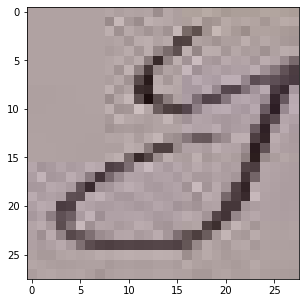

In [73]:
dataiter = iter(train_loader)
itr = dataiter.next()

label = itr['class_name']
img = itr['image']
print("Class name: {}".format(label[0]))

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img[0])

In [0]:
epochs = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(10 + 1)]

In [75]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [0]:
def name_to_int(data):

  switcher = {
      'a': 1,
      'a2': 2,
      'b': 3,
      'c': 4,
      'c2': 5,
      'd': 6,
      'e': 7,
      'e2': 8,
      'e3': 9,
      'f': 10,
      'g': 11,
      'h': 12,
      'i': 13,
      'i2': 14,
      'j': 15,
      'k': 16,
      'l': 17,
      'm': 18,
      'n': 19,
      'y': 20
  }

  new_data = []

  for dt in data:
    new_data.append(switcher.get(dt))

  return new_data

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [86]:
def train(train_loader, val_loader, epoch_amount, save_checkpoint = 10):
  network.eval()
  train_loss_hist = []
  val_loss_hist = []
  checkpoint = save_checkpoint
  for epoch in range(epoch_amount):
    num_images_train = 0
    num_images_val = 0

    # TRAINING DATASET
    correct = 0
    for data in train_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_train = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(20)
        real_value[labels[idx] - 1] = 1

        if(labels[idx] == get_max_from_tensor(outputs)):
          correct += 1

        loss = criterion(outputs, torch.Tensor(real_value)) 
        
        loss.backward()

        lossSum += loss.item()
        train_loss_hist.append(lossSum)

        optimizer.step()

    # VALIDATION
    for data in val_loader:
      images = data['image']
      labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

      num_images_val = len(images)

      lossSum = 0
      for idx in range(len(images)):
        optimizer.zero_grad()

        outputs = network(images[idx].flatten().float())

        maxIdx = get_max_from_tensor(outputs)
        real_value = np.zeros(20)
        real_value[labels[idx] - 1] = 1
        loss = criterion(outputs, torch.Tensor(real_value)) 

        lossSum += loss.item()
        val_loss_hist.append(lossSum)

    print("Epoch: {} Training loss: {} Eval loss: {} Correct: {}%".format(epoch,train_loss_hist[len(train_loss_hist) - 1],val_loss_hist[len(val_loss_hist) - 1],correct*100/num_images_train))

    if(checkpoint == 0):
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

      checkpoint = save_checkpoint
    else:
      checkpoint -= 1

train(train_loader, val_loader, 20)

Epoch: 0 Training loss: 15.40581577271223 Eval loss: 5.68202655762434 Correct: 7.509881422924901%
Epoch: 1 Training loss: 15.401501629501581 Eval loss: 5.680432949215174 Correct: 7.509881422924901%
Epoch: 2 Training loss: 15.397195529192686 Eval loss: 5.67884173989296 Correct: 7.509881422924901%
Epoch: 3 Training loss: 15.392893634736538 Eval loss: 5.677250571548939 Correct: 7.509881422924901%
Epoch: 4 Training loss: 15.388595771044493 Eval loss: 5.67566491663456 Correct: 7.509881422924901%
Epoch: 5 Training loss: 15.384302116930485 Eval loss: 5.67407451570034 Correct: 7.509881422924901%
Epoch: 6 Training loss: 15.380014307796955 Eval loss: 5.672494143247604 Correct: 7.509881422924901%
Epoch: 7 Training loss: 15.375736240297556 Eval loss: 5.670912966132164 Correct: 7.509881422924901%
Epoch: 8 Training loss: 15.371461611241102 Eval loss: 5.669336035847664 Correct: 7.509881422924901%
Epoch: 9 Training loss: 15.367193095386028 Eval loss: 5.667752910405397 Correct: 7.509881422924901%
Epoch

In [79]:
for data in test_loader:
  images = data['image']
  labels = torch.from_numpy(np.array(name_to_int(data['class_name'])))

  for i in range(len(images)):
    output = network(images[i].flatten().float())
    
    if(get_max_from_tensor(output) == labels[i]):
      print("OK: {} == {}".format(get_max_from_tensor(output), labels[i]))
    else:
      print("False: {} == {}".format(get_max_from_tensor(output), labels[i]))

False: 1 == 4
False: 1 == 9
False: 1 == 10
False: 1 == 18
False: 1 == 5
False: 1 == 10
False: 1 == 19
False: 1 == 7
False: 1 == 17
False: 1 == 15
False: 1 == 12
OK: 1 == 1
False: 1 == 3
OK: 1 == 1
False: 1 == 11
False: 1 == 17
False: 1 == 14
False: 1 == 13
False: 1 == 12
False: 1 == 2
False: 1 == 6
False: 1 == 8
False: 1 == 2
False: 1 == 20
False: 1 == 16
False: 1 == 13
False: 1 == 15
